- https://github.com/terrence-ou/Generative-Deep-Learning-2nd-Edition-PyTorch-JAX

In [ ]:
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import v2
from torchinfo import summary

# Train parameters

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 128
EMBEDDING_DIM = 2
EPOCHS = 10
LEARNING_RATE = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def get_dataloaders():

    # first define a transform function, to turn images into tersors
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Pad(2),
    ])

    # load MNIST dataset
    train_ds = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    test_ds = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)
    train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4)
    return train_loader, test_loader

In [ ]:
train_loader, test_loader = get_dataloaders()
print(next(iter(train_loader))[0].shape)

torch.Size([128, 1, 32, 32])


# Build the AutoEncoder

In [ ]:
# Encoder
class Encoder(nn.Module):

    def __init__(self, latents):
        super().__init__()
        self.latents = latents
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=self.latents)
        )

    def forward(self, x):
        return self.model(x)

# Decoder
class Decoder(nn.Module):
    
    def __init__(self, latents):
        super().__init__()
        self.latents = latents
        self.fc = nn.Linear(self.latents, 2048)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                   kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.model(x)
        return x

In [ ]:
encoder = Encoder(EMBEDDING_DIM).to(device)
summary(encoder, input_size=(1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           320
│    └─ReLU: 2-2                         [1, 32, 16, 16]           --
│    └─Conv2d: 2-3                       [1, 64, 8, 8]             18,496
│    └─ReLU: 2-4                         [1, 64, 8, 8]             --
│    └─Conv2d: 2-5                       [1, 128, 4, 4]            73,856
│    └─ReLU: 2-6                         [1, 128, 4, 4]            --
│    └─Flatten: 2-7                      [1, 2048]                 --
│    └─Linear: 2-8                       [1, 2]                    4,098
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
Total mult-adds (M): 2.45
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.39
Estimated Total Size (MB): 0.51

In [ ]:
decoder = Decoder(EMBEDDING_DIM).to(device)
summary(decoder, input_size=(1, EMBEDDING_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 1, 32, 32]            --
├─Linear: 1-1                            [1, 2048]                 6,144
├─Sequential: 1-2                        [1, 1, 32, 32]            --
│    └─ConvTranspose2d: 2-1              [1, 128, 8, 8]            147,584
│    └─ReLU: 2-2                         [1, 128, 8, 8]            --
│    └─ConvTranspose2d: 2-3              [1, 64, 16, 16]           73,792
│    └─ReLU: 2-4                         [1, 64, 16, 16]           --
│    └─ConvTranspose2d: 2-5              [1, 32, 32, 32]           18,464
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-7                       [1, 1, 32, 32]            289
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
Total mult-adds (M): 47.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.99
Estimated Total Size (MB):

In [ ]:
# AutoEncoder
class AE(nn.Module):
    def __init__(self, latents):
        super().__init__()
        self.encoder = Encoder(latents)
        self.decoder = Decoder(latents)

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)      
        return recon_x

    def generate(self, z):
        return F.sigmoid(self.decoder(z))

ae = AE(EMBEDDING_DIM).to(device)
summary(ae, input_size=(1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 1, 32, 32]            --
├─Encoder: 1-1                           [1, 2]                    --
│    └─Sequential: 2-1                   [1, 2]                    --
│    │    └─Conv2d: 3-1                  [1, 32, 16, 16]           320
│    │    └─ReLU: 3-2                    [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             18,496
│    │    └─ReLU: 3-4                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-5                  [1, 128, 4, 4]            73,856
│    │    └─ReLU: 3-6                    [1, 128, 4, 4]            --
│    │    └─Flatten: 3-7                 [1, 2048]                 --
│    │    └─Linear: 3-8                  [1, 2]                    4,098
├─Decoder: 1-2                           [1, 1, 32, 32]            --
│    └─Linear: 2-2                       [1, 2048]                 6,144


# Define the model, objective, and optimizer

In [ ]:
ae = AE(EMBEDDING_DIM).to(device)

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=LEARNING_RATE)

# Get dataloaders

In [ ]:
train_loader, test_loader = get_dataloaders()

# Define train and validation functions

In [ ]:
# A single epoch train funcion
def train(model, dataloader, optimizer, loss_fn):

    model.train()
    train_loss = 0

    for (train_x, _) in tqdm(dataloader):
        optimizer.zero_grad()
        train_x = train_x.to(device)
        recon_x = model(train_x)
        loss = loss_fn(recon_x, train_x)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(dataloader)

# Validation function
def validate(model, dataloader, loss_fn):
    
    model.eval()
    test_loss = 0
    for (test_x, _) in tqdm(dataloader):
        test_x = test_x.to(device)
        with torch.no_grad():
            recon_x = model(test_x)
            loss = loss_fn(recon_x, test_x)

        test_loss += loss
    return test_loss / len(dataloader)

# Train and evaluate

In [ ]:
for i in range(EPOCHS):
    train_loss = train(ae, train_loader, optim, loss_fn)
    test_loss = validate(ae, test_loader, loss_fn)

    print(f'Epoch {i + 1}')
    print(f'\tTrain - loss: {train_loss:.4f}')
    print(f'\tValid - loss: {test_loss:.4f}')

100%|██████████| 79/79 [00:01<00:00, 55.71it/s]


Epoch 1
	Train - loss: 0.0398
	Valid - loss: 0.0346


100%|██████████| 79/79 [00:01<00:00, 50.81it/s]


Epoch 2
	Train - loss: 0.0334
	Valid - loss: 0.0323


100%|██████████| 79/79 [00:01<00:00, 60.19it/s]


Epoch 3
	Train - loss: 0.0320
	Valid - loss: 0.0317


100%|██████████| 79/79 [00:01<00:00, 40.67it/s]


Epoch 4
	Train - loss: 0.0312
	Valid - loss: 0.0313


100%|██████████| 79/79 [00:01<00:00, 68.60it/s]


Epoch 5
	Train - loss: 0.0306
	Valid - loss: 0.0303


100%|██████████| 79/79 [00:01<00:00, 66.33it/s]


Epoch 6
	Train - loss: 0.0302
	Valid - loss: 0.0301


100%|██████████| 79/79 [00:01<00:00, 62.88it/s]


Epoch 7
	Train - loss: 0.0298
	Valid - loss: 0.0299


100%|██████████| 79/79 [00:01<00:00, 66.92it/s]


Epoch 8
	Train - loss: 0.0295
	Valid - loss: 0.0296


100%|██████████| 79/79 [00:01<00:00, 63.64it/s]


Epoch 9
	Train - loss: 0.0293
	Valid - loss: 0.0297


100%|██████████| 79/79 [00:01<00:00, 61.01it/s]

Epoch 10
	Train - loss: 0.0291
	Valid - loss: 0.0293


# Reconstruct using the `AutoEncoder`

In [ ]:
def plot_imgs(imgs, cmap='gray'):
    plt.figure(figsize=(20, 3))
    num_img = imgs.shape[0]

    for i in range(num_img):
        plt.subplot(1, num_img, i + 1)
        plt.axis('off')
        plt.imshow(imgs[i], cmap=cmap)

    plt.show()

In [ ]:
num_samples = 5000
num_iters = np.ceil(num_samples / BATCH_SIZE).astype(int)

# Get samples
for i, (test_x, test_y) in enumerate(test_loader):
    
    if i == 0:
        batch_samples = test_x
        batch_labels = test_y
    else:
        batch_samples = torch.concatenate([batch_samples, test_x])
        batch_labels = torch.concatenate([batch_labels, test_y])
    if i == num_iters - 1: break

batch_samples = batch_samples.to(device)
with torch.inference_mode():
    recon_x = ae(batch_samples)

print(batch_samples.shape)
print(recon_x.shape)

torch.Size([5120, 1, 32, 32])
torch.Size([5120, 1, 32, 32])


Original Images:


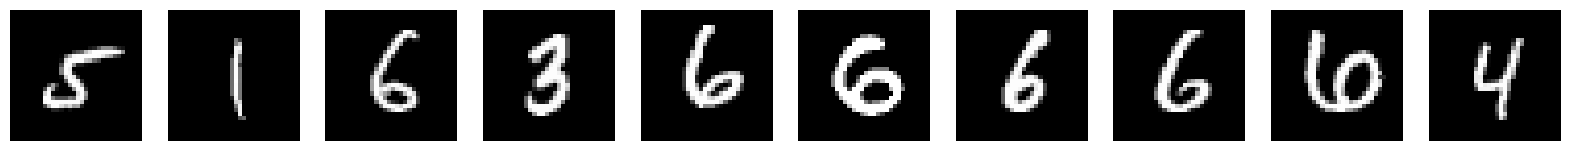

Reconstructed Images:


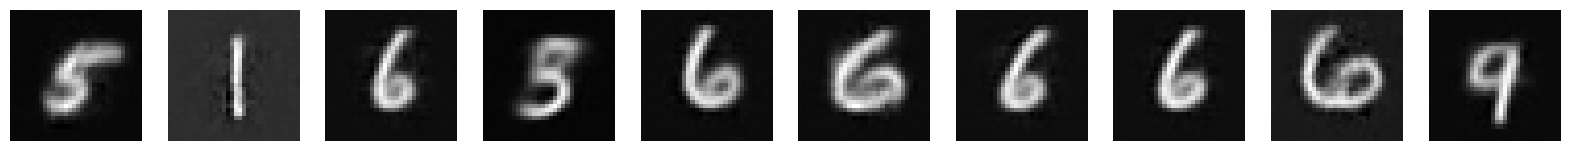

In [ ]:
# randomly sample 10 images from the original set and reconstructed set
img_choices = np.random.choice(num_samples, size=10)
original_imgs = batch_samples[img_choices].permute(0, 2, 3, 1)
recons_imgs = F.sigmoid(recon_x[img_choices]).permute(0, 2, 3, 1)

print('Original Images:')
plot_imgs(original_imgs.detach().cpu().numpy())

print('Reconstructed Images:')
plot_imgs(recons_imgs.detach().cpu().numpy())

# Embed using `Encoder`

In [ ]:
with torch.inference_mode():
    output_embs = ae.encoder(batch_samples)
output_labels = batch_labels

output_embs = output_embs.detach().cpu().numpy()
output_labels = output_labels.detach().cpu().numpy()

print(output_embs.shape)

(5120, 2)


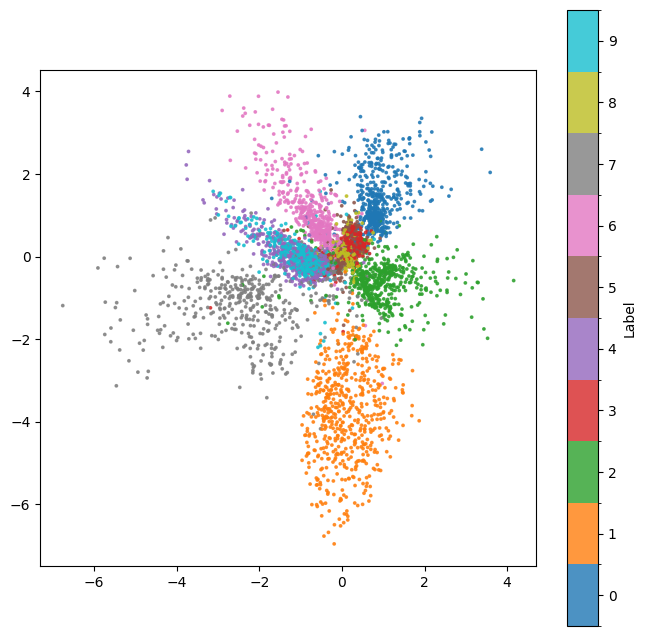

In [ ]:
num_classes = len(np.unique(output_labels))
colors = plt.get_cmap('tab10').colors
cmap = ListedColormap(colors[:num_classes])
norm = BoundaryNorm(np.arange(-0.5, num_classes, 1), cmap.N)

plt.figure(figsize=(8, 8))
plt.scatter(
    output_embs[:, 0], 
    output_embs[:, 1], 
    c=output_labels, 
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    s=3
)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(ticks=np.arange(num_classes), label='Label')
plt.show()

# Generate using `Decoder`

In [ ]:
grid_width, grid_height = (6, 3)
z_samples = torch.randn(size=(grid_width * grid_height, 2))
print(z_samples.shape)

with torch.inference_mode():
    generated_imgs = ae.generate(z_samples.to(device))

generated_imgs = generated_imgs.permute(0, 2, 3, 1).detach().cpu().numpy()
print(generated_imgs.shape)

torch.Size([18, 2])
(18, 32, 32, 1)


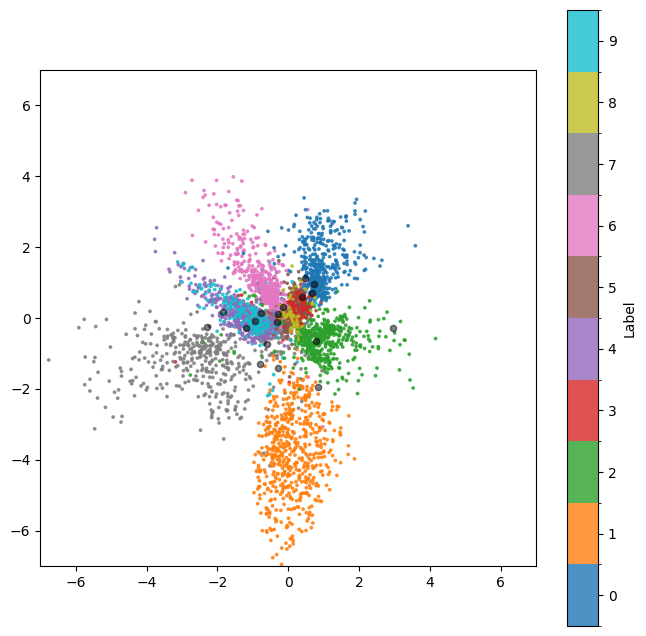

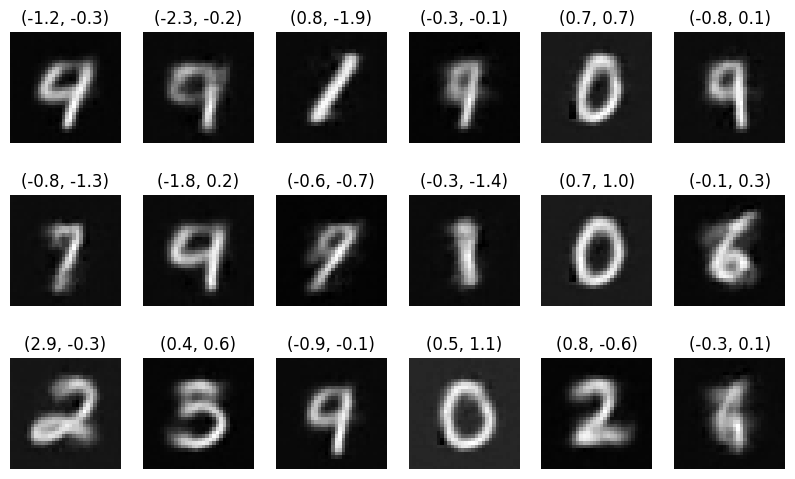

In [ ]:
# Plot the 5000 embeddings and sampled 16 embeddings
plt.figure(figsize=(8, 8))
plt.scatter(
    output_embs[:, 0], 
    output_embs[:, 1], 
    c=output_labels, 
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    s=3
)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(ticks=np.arange(num_classes), label='Label')
plt.scatter(z_samples[:, 0], 
            z_samples[:, 1], 
            c='black', 
            alpha=0.5,
            s=20)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.show()

# Generate new images from sampled embeddings
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(10, 6))
for i in range(generated_imgs.shape[0]):
    curr_row = i // 6
    curr_col = i % 6
    ax = axes[curr_row, curr_col]
    
    ax.set_title(f'({z_samples[i][0]:.1f}, {z_samples[i][1]:.1f})')
    ax.axis('off')
    ax.imshow(generated_imgs[i], cmap='gray')

In [ ]:
sample_size = 14

x = np.linspace(-2, 2, sample_size)
y = np.linspace(-2, 2, sample_size)

xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_samples = torch.tensor(list(zip(xv, yv)), dtype=torch.float32)
print(z_samples.shape)

with torch.no_grad():
    generated_imgs = ae.generate(z_samples.to(device))

generated_imgs = generated_imgs.permute(0, 2, 3, 1).detach().cpu().numpy()
print(generated_imgs.shape)

torch.Size([196, 2])
(196, 32, 32, 1)


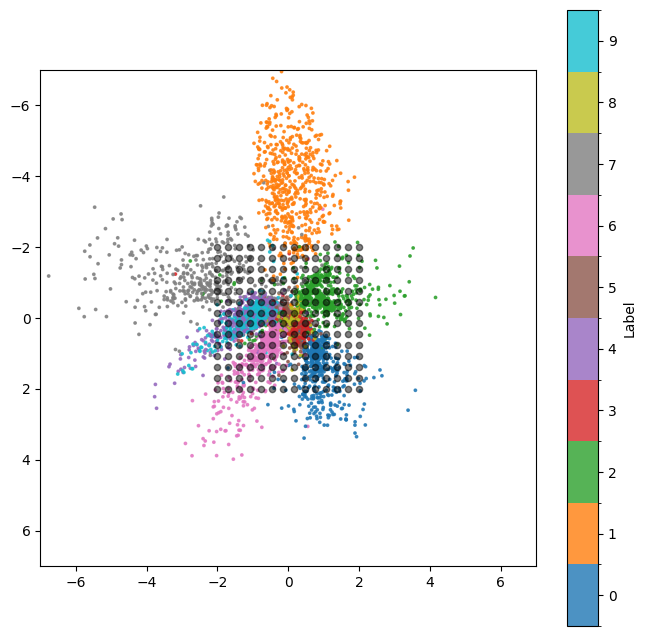

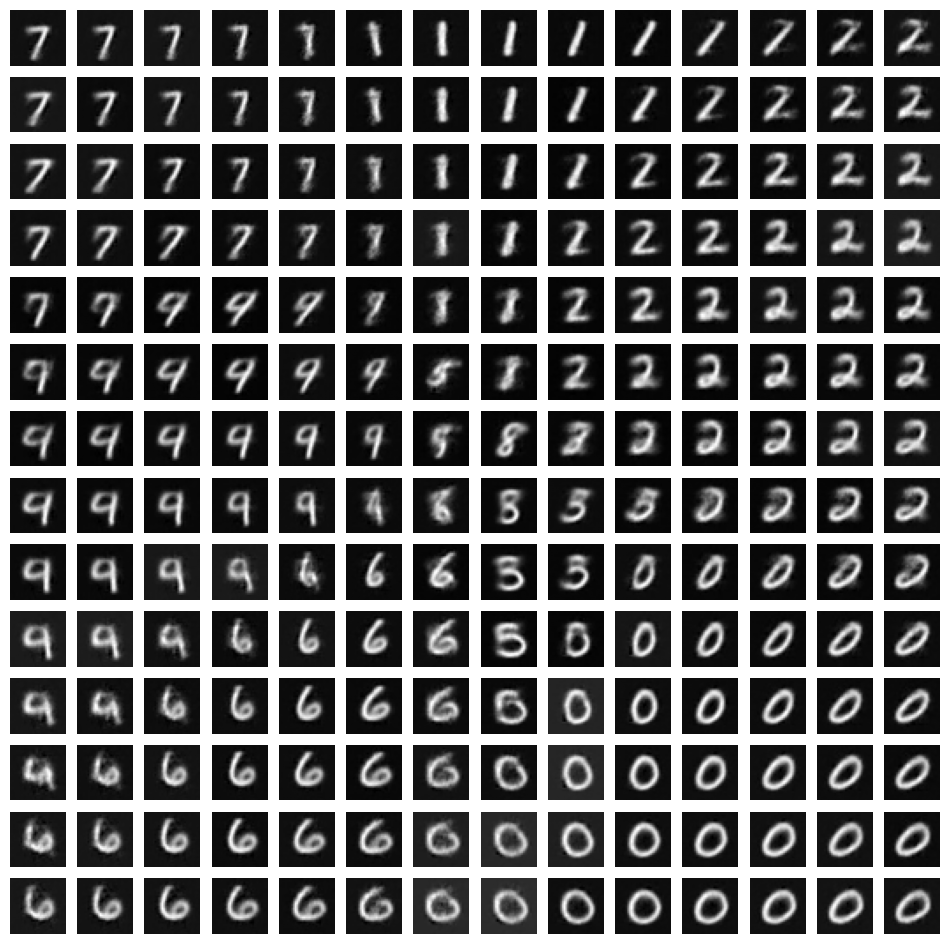

In [ ]:
# Plot the 5000 embeddings and sampled 16 embeddings
plt.figure(figsize=(8, 8))
plt.scatter(
    output_embs[:, 0], 
    output_embs[:, 1], 
    c=output_labels, 
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    s=3
)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(ticks=np.arange(num_classes), label='Label')
plt.scatter(z_samples[:, 0], 
            z_samples[:, 1], 
            c='black', 
            alpha=0.5,
            s=20)
plt.xlim(-7, 7)
plt.ylim(7, -7)
plt.show()

# Generate new images from sampled embeddings
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(sample_size**2):
    ax = fig.add_subplot(sample_size, sample_size, i + 1)
    ax.axis("off")
    ax.imshow(generated_imgs[i], cmap="gray")